## Práctica 1 - Detección de paneles de señalización vertical azul en autovías

Se desea construir un sistema para la detección automática de paneles informativos de tráfico de color azul, en imágenes realistas que han sido tomadas desde un coche (ver figura adjunta). Los paneles se han diseñado para que sean fácilmente distinguibles del entorno en cualquier condición de luz, color de fondo y climatología.

![image.png](attachment:image.png)

Observando la imagen adjunta podemos hacernos una idea sobre el tipo de información que nos permitirá distinguir un tipo de otro de panel, e incluso localizarlos en una imagen de carretera. En particular, se distinguen por su forma geométrica rectangular, por las zonas en las que se divide (borde claro y fondo oscuro) o por el color del mismo (azul y blanco). Es decir, para detectar este tipo de paneles podríamos utilizar:
- Un detector de regiones de alto contraste (detectaríamos la parte interna del panel).
- Un algoritmo que detectase rectángulos (p.ej., combinando detección de líneas con detectores de esquinas).
- Un algoritmo para descubrir qué píxeles son de color azul en la imagen junto con su distribución espacial.
- Detectar ciertas formas que aparecen en los paneles en localizaciones especiales (símbolo de salida de la autopista por la izquierda o derecha, diversos tipos de flechas, etc.).
- Cualquier otra técnica que tenga en cuenta color y forma.

El objetivo de esta práctica es desarrollar un detector básico de sub-paneles de información en autovías (como se ve en la figura adjunta). Hablamos de sub-paneles porque la idea es detectar cada una de las regiones rectangulares azules enmarcadas con un borde blanco en los paneles de la carretera. Para desarrollar el algoritmo de detección, como en muchos otros problemas de este tipo, se ofrece una
colección de imágenes de test tomadas desde un coche.

![image-2.png](attachment:image-2.png)

# Detección de regiones de alto contraste

Utilizar MSER como detector de regiones de alto contraste (mser.detectRegions). 

Cargar las imágenes de aprendizaje en color, guardarlas en una lista y mostrar la primera y la última usando imshow de matplotlib.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def cargarImagenesColor(path):
    filesImages = os.listdir(path)
    imagenesColor = []
    for file in filesImages:
        imagen = cv2.imread(path+"/"+file)
        imagenesColor.append(imagen)
    return imagenesColor

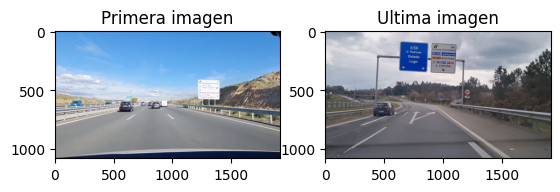

In [2]:
imagenesColor = cargarImagenesColor("imagenesTest")
primeraImagen = imagenesColor[0]
primeraImagen = cv2.cvtColor(primeraImagen, cv2.COLOR_BGR2RGB)
ultimaImagen = imagenesColor[len(imagenesColor)-1]
ultimaImagen = cv2.cvtColor(ultimaImagen, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("Primera imagen")
plt.imshow(primeraImagen)
plt.subplot(1,2,2)
plt.title("Ultima imagen")
plt.imshow(ultimaImagen)

Pasar las imágenes cargadas a niveles de gris (y, posiblemente, mejorar su contraste con las técnicas vistas en clase). Mostrar la primera y la última usando imshow de matplotlib.

In [3]:
def transformarGrises(imagenesColor):
    imagenesGrises = []
    for imagen in imagenesColor:
        imagenesGrises.append(cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY))
    return imagenesGrises

def equializarImagenes(imagenes):
    imagenesEqualizadas = []
    for imagen in imagenes:
        imagenesEqualizadas.append(cv2.equalizeHist(imagen))
    return imagenesEqualizadas

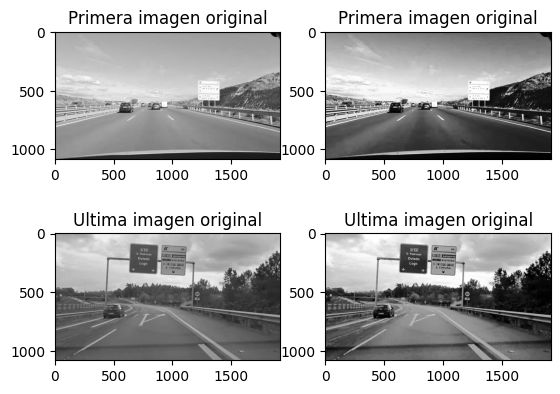

In [4]:
imagenesGrises = transformarGrises(imagenesColor)
imagenesEqualizadas = equializarImagenes(imagenesGrises)

primeraImagen = imagenesGrises[0]
ultimaImagen = imagenesGrises[len(imagenesColor)-1]

# Realiamos un contraste con el equalizador
primeraImagenContraste = imagenesEqualizadas[0]
ultimaImagenContraste = imagenesEqualizadas[len(imagenesEqualizadas)-1]

plt.subplot(2,2,1)
plt.title("Primera imagen original")
plt.imshow(primeraImagen, cmap="gray")
plt.subplot(2,2,2)
plt.title("Primera imagen original")
plt.imshow(primeraImagenContraste, cmap="gray")
plt.subplot(2,2,3)
plt.title("Ultima imagen original")
plt.imshow(ultimaImagen, cmap="gray")
plt.subplot(2,2,4)
plt.title("Ultima imagen original")
plt.imshow(ultimaImagenContraste, cmap="gray")

Crear una función que aplique MSER a la lista de imágenes. Hay que tener en cuenta que los parámetros de MSER se pueden ajustar en el constructor de la clase (cv2.MSER_create). El ajustar los parámetros puede suponer eliminar muchas detecciones incorrectas (http://stackoverflow.com/questionshttps://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python/17647500/exact-meaning-of-the-parameters-given-to-initialize-mser-in-opencv-2-4-x).

Mostrar el resultado de aplicar la función sobre la primera y la última imagen de la lista usando imshow de matplotlib.

In [6]:
import numpy as np

def MSER(imagen):
    copy = imagen.copy()
    output = np.zeros((imagen.shape[0], imagen.shape[1]), dtype=np.uint8)  # Salida en escala de grises
    mser = cv2.MSER_create(delta=10, max_variation=0.1, min_area=1000, max_area=45000)
    copy = cv2.adaptiveThreshold(copy, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)
    copy = cv2.Canny(copy, 100, 200)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,3))
    copy = cv2.dilate(copy, kernel)
    polygons, _ = mser.detectRegions(copy)
    for polygon in polygons:
        mask = np.zeros((imagen.shape[0], imagen.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 255)
        output = cv2.bitwise_or(output, mask)
    return copy, polygons

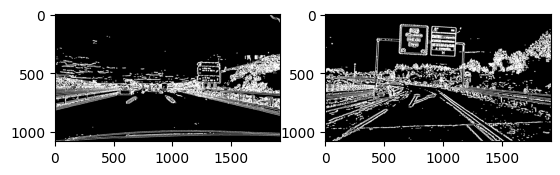

In [9]:
imagenMSERPrimera, _ = MSER(imagenesEqualizadas[0])
imagenMSERUltima, _ = MSER(imagenesEqualizadas[-1])
plt.subplot(1,2,1)
plt.imshow(imagenMSERPrimera, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(imagenMSERUltima, cmap="gray")

Crear una función que extraiga en un rectángulo los píxeles de la región detectada (cv2.boundingRect).

Mostrar gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en el paso anterior.

In [10]:
def obtenerCartel(regionDetectada, imagen):
    imagenCopia = imagen.copy()
    polygons = []
    for polygon in regionDetectada:
        x, y, w, h = cv2.boundingRect(polygon)
        cv2.rectangle(imagenCopia, (x, y), (x + w, y + h), (255, 0, 0), 10)
    return imagenCopia

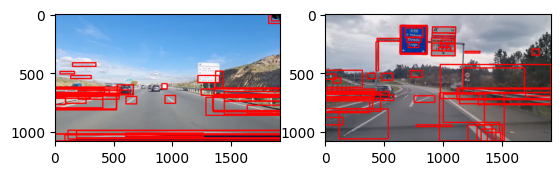

In [12]:
primeraImagenColor = imagenesColor[0]
primeraImagenColor = cv2.cvtColor(primeraImagenColor, cv2.COLOR_BGR2RGB)
ultimaImagenColor = imagenesColor[-1]
ultimaImagenColor = cv2.cvtColor(ultimaImagenColor, cv2.COLOR_BGR2RGB)
_, regionesPrimera = MSER(imagenesEqualizadas[0])
_, regionesUltima = MSER(imagenesEqualizadas[-1])

cuadradosPrimera = obtenerCartel(regionesPrimera, primeraImagenColor)
cuadradosUltima = obtenerCartel(regionesUltima, ultimaImagenColor)
plt.subplot(1,2,1)
plt.imshow(cuadradosPrimera)
plt.subplot(1,2,2)
plt.imshow(cuadradosUltima)

Crear una función que elimine las regiones con una relación de aspecto (ancho/alto) muy diferente de la que tienen los sub-paneles. Si las regiones son demasiado alargadas en horizontal o vertical se podrán eliminar.

Mostrar gráficamente el resultado de aplicar la función sobre alguna imagen que rechace y sobre otra que acepte.

In [34]:
def obtenerSubpanelesFiltrados(regiones, imagen):
    polygons = []
    imagenCopia = imagen.copy()
    for polygon in regiones:
        x, y, w, h = cv2.boundingRect(polygon)
        relacionAspecto = w/h
        if (relacionAspecto >= 2 and relacionAspecto < 7):
            polygons.append(polygon)
            cv2.rectangle(imagenCopia, (x, y), (x + w, y + h), (255, 0, 0), 10)
    return imagenCopia, polygons

def obtenerPanelesFiltrados(regiones, imagen):
    polygons = []
    imagenCopia = imagen.copy()
    for polygon in regiones:
        x, y, w, h = cv2.boundingRect(polygon)
        relacionAspecto = w/h
        if (relacionAspecto >= 0.5 and relacionAspecto < 3):
            polygons.append(polygon)
            cv2.rectangle(imagenCopia, (x, y), (x + w, y + h), (255, 0, 0), 10)
    return imagenCopia, polygons

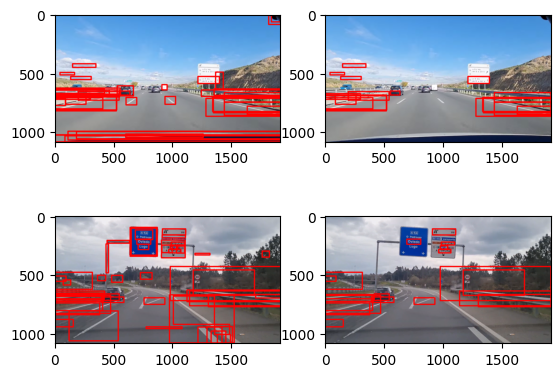

In [26]:
subpanelesPrimera,_ = obtenerSubpanelesFiltrados(regionesPrimera, primeraImagenColor)
subpanelesUltima,_ = obtenerSubpanelesFiltrados(regionesUltima, ultimaImagenColor)
plt.subplot(2,2,1)
plt.imshow(cuadradosPrimera)
plt.subplot(2,2,2)
plt.imshow(subpanelesPrimera)
plt.subplot(2,2,3)
plt.imshow(cuadradosUltima)
plt.subplot(2,2,4)
plt.imshow(subpanelesUltima)

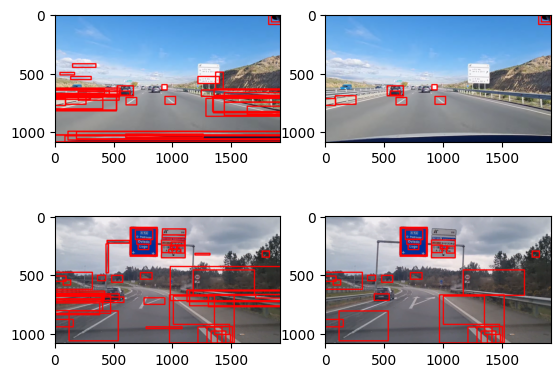

In [35]:
panelesPrimera,_ = obtenerPanelesFiltrados(regionesPrimera, primeraImagenColor)
panelesUltima,_ = obtenerPanelesFiltrados(regionesUltima, ultimaImagenColor)
plt.subplot(2,2,1)
plt.imshow(cuadradosPrimera)
plt.subplot(2,2,2)
plt.imshow(panelesPrimera)
plt.subplot(2,2,3)
plt.imshow(cuadradosUltima)
plt.subplot(2,2,4)
plt.imshow(panelesUltima)

En los sub-paneles, es posible que MSER haya detectado originalmente la región azul interna al borde blanco. Por tanto, es conveniente agrandar un poco el rectángulo detectado para que la imagen recortada contenga el sub-panel completo (incluyendo el borde blanco, y no sólo su parte interna). Si no se hace esto podemos tener una tasa de detección peor de la que realmente tenemos dado que las detecciones no solaparán completamente con las anotaciones.

Crear una función que agrande la zona y que muestre gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en la celda de la función en MSER.

## Detección mediante correlación de máscaras

En esta sección se desea utilizar el espacio de color HSV para localizar los píxeles que sean del color azul (característico del panel) y que estén muy saturados (tiene que ser un azul bastante puro). 

Para ello, en primer lugar se necesita construir una máscara ideal. Por ejemplo un np.array de tamaño fijo (p.ej. 40x80) en el que los píxeles azules y muy saturados tengan valor 1, y 0 el resto. Esta matriz será la máscara de color azul saturado del sub-panel informativo general. La máscara indicaría en qué píxeles debería tener color azul saturado el subpanel.

Mostrar gráficamente la máscara ideal usando imshow.

Crear una función que recorte cada ventana detectada por MSER en una imagen y devuelva una lista de imágenes con un tamaño fijo (p.ej. 40x80 píxeles) usando cv2.resize.

Mostrar gráficamente el resultado de aplicar dicha función sobre una imagen que tenga varios paneles.

Crear una función que extraiga los píxeles de color azul saturado (que llamaremos M) de la ventana redimensionada.

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior.

Crear una función que correle M (multiplicar elemento a elemento y sumar), con la máscara de color azul saturado ideal que debería tener un sub-panel de carretera (p.ej. casi todos los píxeles a 1). Se puede
usar el valor de correlación para saber cuál es la proporción de píxeles de color azul saturado en el sub-panel evaluado. 

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior y que muestre también el valor numérico de dicha correlación.

Si se pone un umbral también se pueden rechazar ventanas como “no panel” cuando tienen una correlación muy baja (es decir, las que “tienen poco azul”).

Si al correlar se supera el umbral, establecer el valor de correlación como la puntuación, o score, que daremos a esa ventana detectada. Ello nos indicará “cómo de parecido es lo detectado a un sub-panel” esa parte de la imagen (0 no es sub-panel y 1 sí lo es).

Establecer un umbral que permita rechazar algunas imágenes que realmente habría que rechazar y que acepte algunas imágenes que debería aceptar.

Mostrar gráficamente algunas imágenes, los valores de correlación obtenidos y el resultado de aplicar el umbral.

## Eliminación de detecciones repetidas

MSER detecta la parte interna del sub-panel (p.ej. la parte azul dentro del borde blanco) varias veces dependiendo de los parámetros que le pasemos y además la parte externa (el borde), con lo que muy probablemente tendremos más de una detección correspondiente a cada sub-panel. En esta parte de la práctica se pide diseñar un algoritmo para la que las ventanas repetidas se queden reducidas a una sola detección. Este algoritmo puede utilizar alguna de las siguientes ideas:
- Definir un criterio de solapamiento de ventanas (p.ej. el área de la intersección dividido por el área de la unión de dos ventanas).
- Elegir la ventana que contenga a otras de las que se solapen.
- Elegir la ventana promedio de las que solapen.
- Otros criterios propuestos por los alumnos.

Crear una función filtre los resultados de MSER y mostrar los resultados de aplicar dicha función sobre algunos ejemplos donde tenga impacto.

In [53]:
def intersectionOverUnion(box1, box2):
    x, y, w, h = cv2.boundingRect(box1)
    xA1 = x
    yA1 = y
    x = x + w
    y = y + h
    xA2 = x
    yA2 = y
    x, y, w, h = cv2.boundingRect(box2)
    xB1 = x
    yB1 = y
    x = x + w
    y = y + h
    xB2 = x
    yB2 = y
    x1 = max(xA1, xB1)
    y1 = max(yA1, yB1)
    x2 = min(xA2, xB2)
    y2 = min(yA2, yB2)
    intersectionArea = (x2 - x1) * (y2 - y1)
    if (intersectionArea < 0):
        intersectionArea = 0
    box1Area = abs((xA2 - xA1) * (yA1 - yA2))
    box2Area = abs((xB2 - xB1) * (yB1 - yB2))
    return intersectionArea / (box1Area + box2Area - intersectionArea + 1e-6)

37
0.10420624151401865


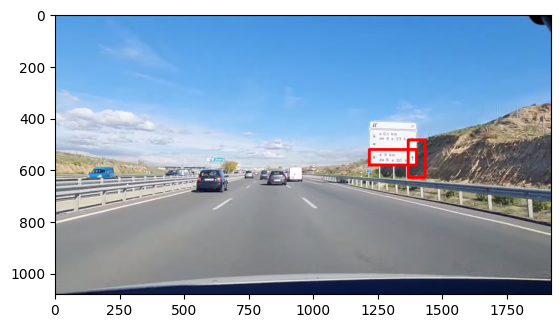

In [65]:
regionesPrueba = []
print(len(regionesPrimera))
regionesPrueba.append(regionesPrimera[2])
regionesPrueba.append(regionesPrimera[4])
imagenPrueba = obtenerCartel(regionesPrueba, primeraImagenColor)
plt.imshow(imagenPrueba)
print(intersectionOverUnion(regionesPrimera[2], regionesPrimera[4]))

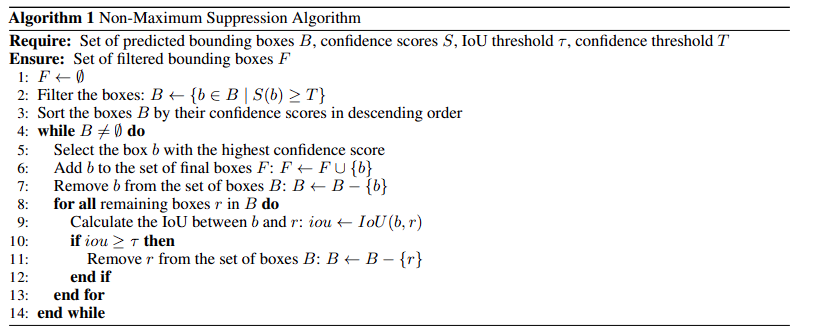

In [ ]:
def nms(boxes, umbral):
    boxesResult = []
    for i in range(len(boxes)):
        for j in range(len(boxes)):
            box1 = boxes[i]
            box2 = boxes[j]
            value = intersectionOverUnion(box1, box2)

In [73]:
def nonMaximumSuppression(boxes, overlapThreshold):
    # Si no hay cajas, retornamos una lista vacía
    if len(boxes) == 0:
        return []

    # Convertir las coordenadas de las cajas a coordenadas (x, y, x+w, y+h)
    boxes = [[x, y, x + w, y + h] for (x, y, w, h) in boxes]

    # Inicializar la lista de cajas seleccionadas
    pickedBoxes = []

    # Obtener las coordenadas de las cajas
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Calcular el área de cada caja
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Ordenar las cajas por su coordenada y2
    indices = np.argsort(y2)

    # Iterar sobre los índices ordenados
    while len(indices) > 0:
        # Obtener el índice de la última caja en la lista ordenada
        last = len(indices) - 1
        index = indices[last]
        pickedBoxes.append(index)

        # Calcular las coordenadas del rectángulo de intersección
        xx1 = np.maximum(x1[index], x1[indices[:last]])
        yy1 = np.maximum(y1[index], y1[indices[:last]])
        xx2 = np.minimum(x2[index], x2[indices[:last]])
        yy2 = np.minimum(y2[index], y2[indices[:last]])

        # Calcular el área de intersección
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        intersection = w * h

        # Calcular el índice de superposición
        overlap = intersection / (area[index] + area[indices[:last]] - intersection)

        # Eliminar índices de las cajas que tienen una superposición mayor que el umbral
        indices = np.delete(indices, np.concatenate(([last], np.where(overlap > overlapThreshold)[0])))

    # Retornar las cajas seleccionadas
    return pickedBoxes

In [75]:
boxesPrueba = []
for cuadrado in cuadradosUltima:
    x,y,w,h = cv2.boundingRect(cuadrado)
    boxesPrueba.append((x,y,w,h))
nonMaximumSuppression(boxesPrueba, 0.5)

TypeError: list indices must be integers or slices, not tuple

## Evaluación de los resultados de detección

Seleccionar un subconjunto de, al menos, 20 imágenes del conjunto de imágenes de test proporcionado. Estas imágenes deben de ser lo suficientemente representativas como para contener todas las variabilidades presentes en el dataset de imágenes (p.ej., diferentes condiciones meteorológicas, diferentes tamaños y perspectivas de los sub-paneles en las escenas, etc). 

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

Para las 20 imágenes de test seleccionadas, pintar (por ejemplo, en color rojo), los rectángulos donde se han detectado los sub-paneles en cada una de las imágenes consideradas.

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

Mostrar resultados cuantitativos de detección usando la métrica de IoU (Intersection over Union)

## Normalización de las imágenes de los paneles detectados

Muchos paneles detectados en las imágenes pueden aparecer ligeramente rotados (debido al efecto de la perspectiva) y/o también afectados por unas condiciones de iluminación desfavorable. Ello puede  dificultar el posterior reconocimiento de la información contenida en los mismos. La Figura adjunta ilustra un ejemplo de esta situación.

![image-2.png](attachment:image-2.png)

En este apartado se pide desarrollar una función que aplique las normalizaciones que se consideren con respecto a la posición del cartel en la imagen y/o la corrección del efecto de la iluminación.

Mostrar gráficamente el resultado de aplicar dicha normalización sobre un conjunto de imágenes que lo requieran.